In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

In [2]:
import sys
print(sys.version)

3.12.6 (v3.12.6:a4a2d2b0d85, Sep  6 2024, 16:08:03) [Clang 13.0.0 (clang-1300.0.29.30)]


In [3]:
# Load data
df = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

In [4]:
# Initial inspection
print(f"Dataset shape: {df.shape}")
display(df.head(5))

Dataset shape: (218083, 11)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218083 entries, 0 to 218082
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                218083 non-null  object 
 1   town                 218083 non-null  object 
 2   flat_type            218083 non-null  object 
 3   block                218083 non-null  object 
 4   street_name          218083 non-null  object 
 5   storey_range         218083 non-null  object 
 6   floor_area_sqm       218083 non-null  float64
 7   flat_model           218083 non-null  object 
 8   lease_commence_date  218083 non-null  int64  
 9   remaining_lease      218083 non-null  object 
 10  resale_price         218083 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 18.3+ MB
None


In [6]:
# Check for missing values
print("\nMissing values per column:")
missing_data = df.isna().sum()
print(missing_data[missing_data > 0])


Missing values per column:
Series([], dtype: int64)


In [7]:
# Set pandas display options to suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Display the statistics again with the new format
print("\nTarget variable resale_price' statistics (formatted):")
print(df['resale_price'].describe())

# Reset pandas display options to default (optional)
# pd.reset_option('display.float_format')


Target variable resale_price' statistics (formatted):
count    218083.00
mean     522062.97
std      185178.47
min      140000.00
25%      385000.00
50%      490000.00
75%      628000.00
max     1658888.00
Name: resale_price, dtype: float64


In [8]:
drop_cols = ["block"]

In [9]:
display(df.head(5))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00


Text(0, 0.5, 'Frequency')

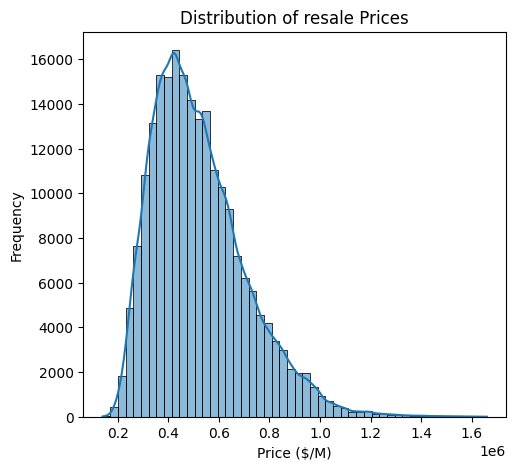

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['resale_price'], bins=50, kde=True)
plt.title('Distribution of resale Prices')
plt.xlabel('Price ($/M)')
plt.ylabel('Frequency')

In [11]:
# Check for extreme outliers
Q1 = df['resale_price'].quantile(0.25)
Q3 = df['resale_price'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 3 * IQR
print(f"Outlier threshold (Q3 + 3*IQR): ${outlier_threshold:.2f}")
print(f"Number of extreme outliers: {(df['resale_price'] > outlier_threshold).sum()}")

Outlier threshold (Q3 + 3*IQR): $1357000.00
Number of extreme outliers: 213


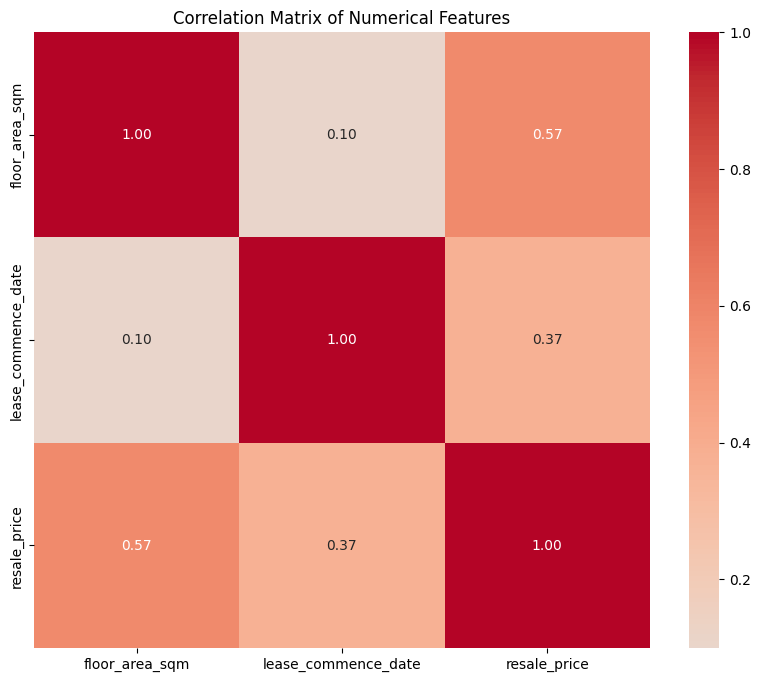

In [12]:
# Numerical features correlation
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[num_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

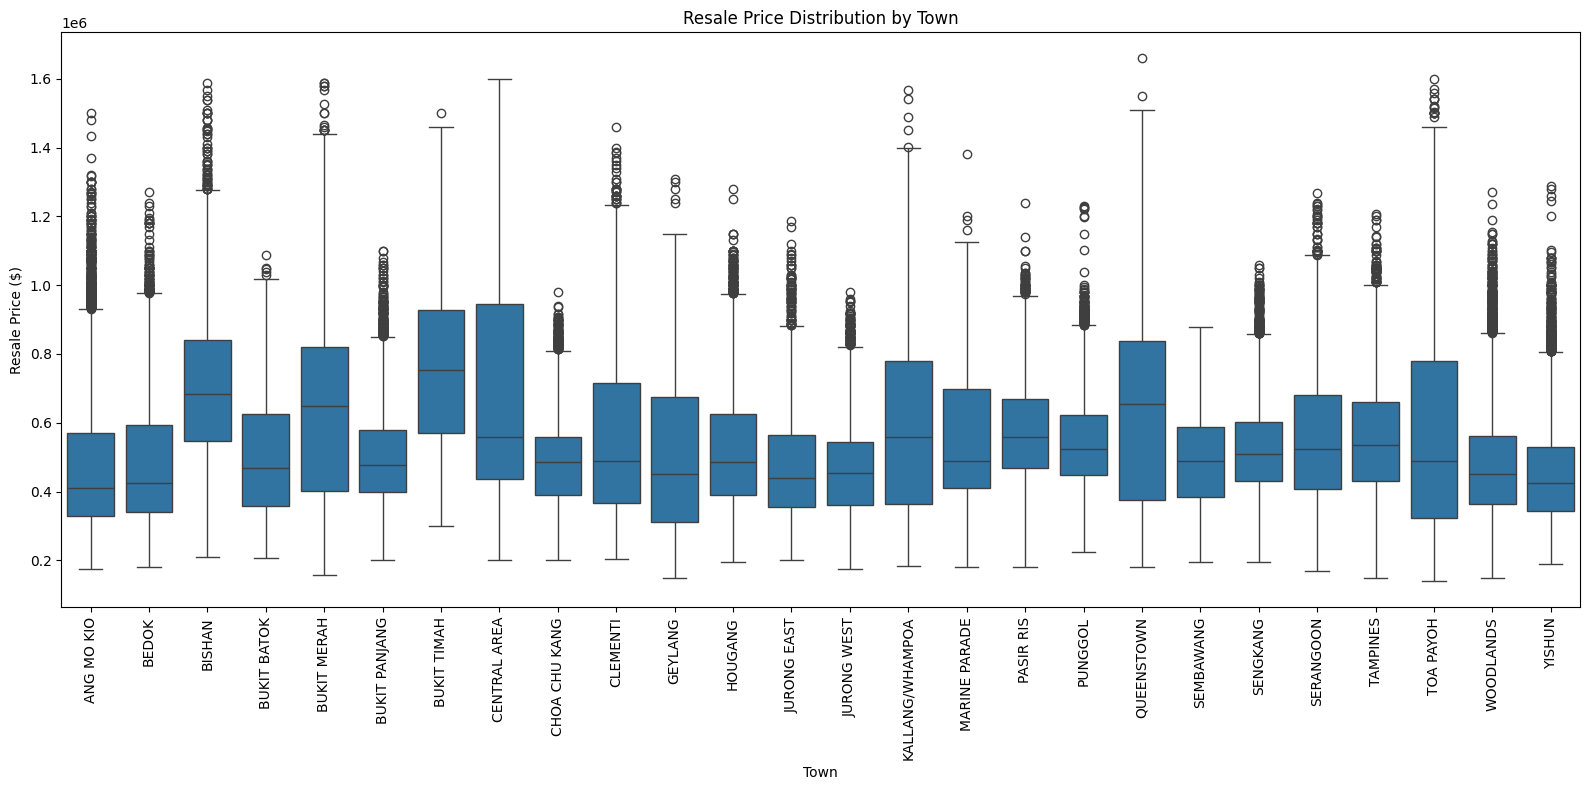

In [13]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='town', y='resale_price', data=df)
plt.title('Resale Price Distribution by Town')
plt.xlabel('Town')
plt.ylabel('Resale Price ($)')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [14]:
# Define region mappings
region_mapping = {
    'central region': [
        'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'DOWNTOWN CORE', 'GEYLANG',
        'KALLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'MUSEUM', 'NEWTON', 'NOVENA', 'ORCHARD',
        'OUTRAM', 'QUEENSTOWN', 'RIVER VALLEY', 'ROCHOR', 'SINGAPORE RIVER',
        'SOUTHERN ISLANDS', 'STRAITS VIEW', 'TANGLIN', 'TOA PAYOH', 'HOLLAND', 'CENTRAL AREA'
    ],
    'east region': [
        'BEDOK', 'CHANGI', 'CHANGI BAY', 'PAYA LEBAR', 'TAMPINES', 'PASIR RIS'
    ],
    'north region': [
        'CENTRAL WATER CATCHMENT', 'LIM CHU KANG', 'MANDAI', 'SEMBAWANG',
        'SIMPANG', 'SUNGEI KADUT', 'WOODLANDS', 'YISHUN'
    ],
    'north-east region': [
        'ANG MO KIO', 'HOUGANG', 'NORTH-EASTERN ISLANDS', 'PUNGGOL',
        'SELETAR', 'SENGKANG', 'SERANGOON'
    ],
     'west region': [
         'BOON LAY', 'BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST', 'PIONEER', 'TENGAH', 'TUAS', 'WESTERN WATER CATCHMENT'
     ]
}

# Function to assign region based on town
def assign_region(town):
    town_upper = town.upper()
    for region, towns in region_mapping.items():
        if town_upper in [t.upper() for t in towns]:
            return region
    return 'other region'  # For towns not in any specified region

# Apply the function to create the new region column
df['region'] = df['town'].apply(assign_region)

# Display the result
print("Region distribution:")
print(df['region'].value_counts())
print(f"\nTotal rows: {len(df)}")
print(f"Rows with 'other region': {(df['region'] == 'other region').sum()}")

# Display first few rows to verify
display(df[['town', 'region']].head(10))

Region distribution:
region
north-east region    57599
west region          50438
central region       40677
north region         36889
east region          32480
Name: count, dtype: int64

Total rows: 218083
Rows with 'other region': 0


,town,region
0,ANG MO KIO,north-east region
1,ANG MO KIO,north-east region
2,ANG MO KIO,north-east region
3,ANG MO KIO,north-east region
4,ANG MO KIO,north-east region
5,ANG MO KIO,north-east region
6,ANG MO KIO,north-east region
7,ANG MO KIO,north-east region
8,ANG MO KIO,north-east region
9,ANG MO KIO,north-east region


In [15]:
# Display rows classified under 'other region'
other_region_rows = df[df['region'] == 'other region']

print(f"Number of rows in 'other region': {len(other_region_rows)}")
print("\nSample of towns classified as 'other region':")
print(other_region_rows['town'].value_counts().head(20))

print("\nSample rows from 'other region':")
display(other_region_rows[['town', 'region']].head(15))

Number of rows in 'other region': 0

Sample of towns classified as 'other region':
Series([], Name: count, dtype: int64)

Sample rows from 'other region':


,town,region


In [16]:
# More detailed view of 'other region' towns
print("\nDetailed breakdown of 'other region' towns:")
other_region_towns = other_region_rows['town'].value_counts()
print(other_region_towns)

print(f"\nTotal unique towns in 'other region': {len(other_region_towns)}")

# Display a few complete rows from 'other region'
print("\nComplete sample rows from 'other region':")
display(other_region_rows.head(10))


Detailed breakdown of 'other region' towns:
Series([], Name: count, dtype: int64)

Total unique towns in 'other region': 0

Complete sample rows from 'other region':


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region


In [17]:
display(df.head(5))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00,north-east region
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00,north-east region
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00,north-east region
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00,north-east region
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00,north-east region


In [18]:
# Create price per sqft column
df['price_per_sqft'] = df['resale_price'] / (df['floor_area_sqm'] * 10.7639)

# Display the result
print("Price per sqft statistics:")
print(df['price_per_sqft'].describe())

# Display first few rows to verify
display(df[['resale_price', 'floor_area_sqm', 'price_per_sqft']].head(10))

Price per sqft statistics:
count   218083.00
mean       506.40
std        148.37
min        194.13
25%        401.50
50%        480.53
75%        574.40
max       1500.29
Name: price_per_sqft, dtype: float64


,resale_price,floor_area_sqm,price_per_sqft
0,232000.00,44.00,489.85
1,250000.00,67.00,346.65
2,262000.00,67.00,363.29
3,265000.00,68.00,362.05
4,265000.00,67.00,367.45
5,275000.00,68.00,375.71
6,280000.00,68.00,382.54
7,285000.00,67.00,395.18
8,285000.00,68.00,389.37
9,285000.00,67.00,395.18


In [19]:
display(df.head(5))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,region,price_per_sqft
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.00,Improved,1979,61 years 04 months,232000.00,north-east region,489.85
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.00,New Generation,1978,60 years 07 months,250000.00,north-east region,346.65
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,262000.00,north-east region,363.29
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.00,New Generation,1980,62 years 01 month,265000.00,north-east region,362.05
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.00,New Generation,1980,62 years 05 months,265000.00,north-east region,367.45


In [20]:
# Import all required Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#import warnings
#warnings.filterwarnings("ignore")  # Hide unnecessary warnings for cleaner output

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import time

In [22]:
# ==========================================================
# 1. DEFINE FEATURES AND TARGET VARIABLE
# ==========================================================

# 'features' are the input columns used to predict the target
# 'target' is the output column we want to predict
features = [
    'floor_area_sqm',         # Size of the flat
    'lease_commence_date',    # Year the lease started
    'region',                 # Custom region grouping (Central, East, etc.)
    'town',                   # Town name (e.g., Bedok, Toa Payoh)
    'flat_type',              # Flat type (3 ROOM, 4 ROOM, etc.)
    'flat_model',             # Model type (Improved, New Generation, etc.)
    'storey_range'            # Storey range (e.g., 01 TO 03, 10 TO 12)
]

target = 'price_per_sqft'     # Predicting price per square foot (normalized measure)

# Extract X (features) and y (target)
X = df[features].copy()
y = df[target].copy()

print(" Features and Target selected.")
print(f"Feature columns: {features}")
print(f"Target column: {target}")
print(f"Shape of dataset: {X.shape[0]} rows, {X.shape[1]} features\n")

# Log transform to reduce the effect of extreme values
y_log = np.log1p(y).ravel()

 Features and Target selected.
Feature columns: ['floor_area_sqm', 'lease_commence_date', 'region', 'town', 'flat_type', 'flat_model', 'storey_range']
Target column: price_per_sqft
Shape of dataset: 218083 rows, 7 features



In [23]:
# ==========================================================
# 2. SPLIT DATA INTO TRAINING AND TEST SETS
# ==========================================================

# We split data into 80% for training and 20% for testing.
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log,
    test_size=0.2,         # 20% test data
    random_state=42,       # Ensures repeatable results every run
    shuffle=True           # Randomize the split to avoid bias
)

# Verify the split sizes
print(" Train-Test Split Done.")
print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set : {X_test.shape[0]} rows\n")

 Train-Test Split Done.
Training set: 174466 rows
Testing set : 43617 rows



In [24]:
# ==========================================================
# 3. DATA PREPROCESSING (ENCODING + SCALING)
# ==========================================================

# Identify categorical and numerical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# OneHotEncoder → converts text categories (like towns) into numeric columns
# StandardScaler → scales numbers so that all features are on a similar range
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'  # Drop any columns not listed above
)

print(" Preprocessing pipeline created.")
print(f"Categorical columns encoded: {cat_cols}")
print(f"Numerical columns scaled: {num_cols}\n")

 Preprocessing pipeline created.
Categorical columns encoded: ['region', 'town', 'flat_type', 'flat_model', 'storey_range']
Numerical columns scaled: ['floor_area_sqm', 'lease_commence_date']



In [25]:
# ==========================================================
# 4. DEFINE THREE ML MODEL PIPELINES
# ==========================================================

# 1. Linear Regression - baseline model assuming a linear relationship
lr_pipe = Pipeline([
    ('preprocessor', preprocess),
    ('model', LinearRegression())
])

# 2. Random Forest - ensemble of many decision trees for better performance
rf_pipe = Pipeline([
    ('preprocessor', preprocess),
    ('model', RandomForestRegressor(
        random_state=42,
        n_estimators=200,        # number of trees
        max_depth=None,          # grow until pure
        min_samples_split=2,
        min_samples_leaf= 1
    ))
])

# 3. MLP Regressor - basic neural network for capturing non-linear patterns
mlp_pipe = Pipeline([
    ('preprocessor', preprocess),
    ('model', MLPRegressor(
        hidden_layer_sizes=(128, 64),  # two layers
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        alpha=1e-4,
        max_iter=500,
        early_stopping=True,           # stops when validation stops improving
        n_iter_no_change=20,
        random_state=42
    ))
])

print(" Model pipelines for LR, RF, and MLP has been defined.\n")


 Model pipelines for LR, RF, and MLP has been defined.



In [26]:
# ==========================================================
# 5. TRAIN, TUNE & EVALUATE — LINEAR REGRESSION (with GridSearchCV)
# ==========================================================
print(" Training Linear Regression model using GridSearchCV...")

from sklearn.model_selection import GridSearchCV

# Define simple parameter grid
param_grid_lr = {
    'model__fit_intercept': [True, False]
}

# Grid Search with 5-fold cross-validation
gs_lr = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid_lr,
    scoring='neg_root_mean_squared_error',  # RMSE as scoring metric
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train on training data
gs_lr.fit(X_train, y_train_log)

# Extract best estimator
best_lr = gs_lr.best_estimator_

# Predict on test data
lr_pred_log_test = best_lr.predict(X_test)

# Predict on training data
lr_pred_log_train = best_lr.predict(X_train)


# Convert back from log scale
y_test_actual = np.expm1(y_test_log)
lr_pred_actual_test = np.expm1(lr_pred_log_test)

y_train_actual = np.expm1(y_train_log)
lr_pred_actual_train = np.expm1(lr_pred_log_train)


# Compute metrics for TEST set
lr_rmse_test = np.sqrt(mean_squared_error(y_test_actual, lr_pred_actual_test))
lr_mae_test = mean_absolute_error(y_test_actual, lr_pred_actual_test)
lr_r2_test = r2_score(y_test_actual, lr_pred_actual_test)

# Compute metrics for TRAIN set
lr_rmse_train = np.sqrt(mean_squared_error(y_train_actual, lr_pred_actual_train))
lr_mae_train = mean_absolute_error(y_train_actual, lr_pred_actual_train)
lr_r2_train = r2_score(y_train_actual, lr_pred_actual_train)

print("\n Linear Regression Model Evaluation (with GridSearchCV):")
print(f"Best Parameters: {gs_lr.best_params_}")
print(f"Cross-Validation RMSE: {-gs_lr.best_score_:.4f}")

print("\n Test Set Metrics:")
print(f"Test RMSE: {lr_rmse_test:,.2f} $/sqft")
print(f"MAE: {lr_mae_test:,.2f} $/sqft")
print(f"R²: {lr_r2_test:.4f}")

print("\n Training Set Metrics:")
print(f"Train RMSE: {lr_rmse_train:,.2f} $/sqft")
print(f"Train MAE: {lr_mae_train:,.2f} $/sqft")
print(f"Train R²: {lr_r2_train:.4f}\n")

 Training Linear Regression model using GridSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

 Linear Regression Model Evaluation (with GridSearchCV):
Best Parameters: {'model__fit_intercept': False}
Cross-Validation RMSE: 0.1752

 Test Set Metrics:
Test RMSE: 88.10 $/sqft
MAE: 71.58 $/sqft
R²: 0.6439

 Training Set Metrics:
Train RMSE: 88.53 $/sqft
Train MAE: 71.94 $/sqft
Train R²: 0.6449



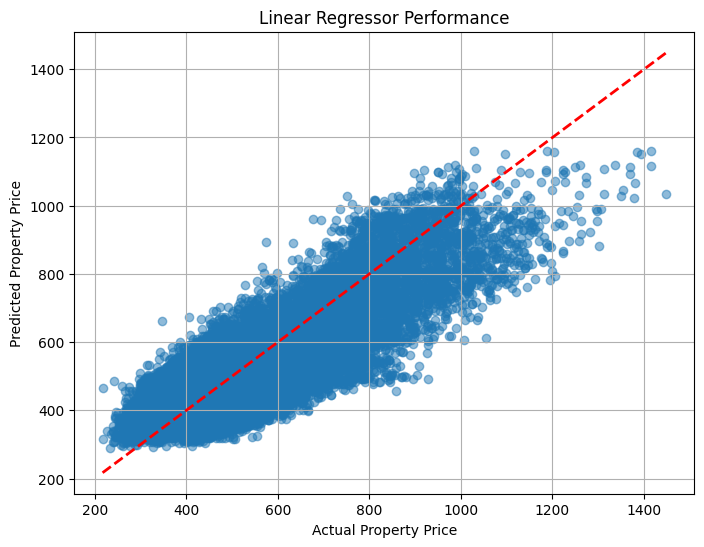

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, lr_pred_actual_test, alpha=0.5)  # alpha for transparency
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)  # Ideal line
plt.xlabel("Actual Property Price")
plt.ylabel("Predicted Property Price")
plt.title("Linear Regressor Performance")
plt.grid(True)
plt.show()

In [28]:
# ==========================================================
# 6. TRAIN, TUNE & EVALUATE — RANDOM FOREST (with RandomizedSearchCV)
# ==========================================================
print(" Training Random Forest model using RandomizedSearchCV...")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# ----------------------------------------------
# 1. Define the hyperparameter search space
# ----------------------------------------------
# Each key corresponds to a RandomForest parameter.
# RandomizedSearchCV will sample 15 random combinations from these ranges.
param_dist_rf = {
    'model__n_estimators': randint(100, 500),       # number of trees in the forest
    'model__max_depth': randint(5, 50),             # maximum depth of trees
    'model__min_samples_split': randint(2, 20),     # min samples required to split a node
    'model__min_samples_leaf': randint(1, 10),      # min samples required at a leaf node
    'model__max_features': ['sqrt', 'log2', 1.0]    # number of features considered at each split
}

# ----------------------------------------------
# 2. Setup the RandomizedSearchCV
# ----------------------------------------------
# RandomizedSearchCV performs random combinations of parameters instead of all (GridSearch).
# This speeds up tuning significantly for large models like Random Forests.
rs_rf = RandomizedSearchCV(
    estimator=rf_pipe,                 # our pipeline (preprocessing + model)
    param_distributions=param_dist_rf, # parameter space
    n_iter=15,                         # test 15 random parameter combinations
    cv=3,                              # 3-fold cross-validation
    n_jobs=2,                          # use 2 CPU cores (balance between speed & stability)
    random_state=42,                   # ensures repeatable random combinations
    verbose=2,                          # prints tuning progress details
    scoring='neg_root_mean_squared_error'
)

# ----------------------------------------------
# 3. Train the model with RandomizedSearchCV
# ----------------------------------------------
print(" Performing hyperparameter tuning (this may take a while) ")
rs_rf.fit(X_train, y_train_log)

# ----------------------------------------------
# 4. Retrieve the best model and parameters
# ----------------------------------------------
best_rf = rs_rf.best_estimator_
print("\n Best Random Forest Parameters Found:")
print(rs_rf.best_params_)

# ----------------------------------------------
# 5. Predict on the test set
# ----------------------------------------------
rf_pred_log_test = best_rf.predict(X_test)

# Predict on the training set
rf_pred_log_train = best_rf.predict(X_train)


# Convert back from log scale to actual price per sqft
y_test_actual = np.expm1(y_test_log)
rf_pred_actual_test = np.expm1(rf_pred_log_test)

y_train_actual = np.expm1(y_train_log)
rf_pred_actual_train = np.expm1(rf_pred_log_train)

# ----------------------------------------------
# 6. Evaluate the model performance
# ----------------------------------------------
# Evaluate on Test Set
rf_rmse_test = np.sqrt(mean_squared_error(y_test_actual, rf_pred_actual_test))
rf_mae_test = mean_absolute_error(y_test_actual, rf_pred_actual_test)
rf_r2_test = r2_score(y_test_actual, rf_pred_actual_test)

# Evaluate on Training Set
rf_rmse_train = np.sqrt(mean_squared_error(y_train_actual, rf_pred_actual_train))
rf_mae_train = mean_absolute_error(y_train_actual, rf_pred_actual_train)
rf_r2_train = r2_score(y_train_actual, rf_pred_actual_train)

# ----------------------------------------------
# 7. Print final evaluation results
# ----------------------------------------------
print("\n Random Forest Model Evaluation (with RandomizedSearchCV):")
print(f"Cross-Validation RMSE: {-rs_rf.best_score_:.4f}")

print("\n Test Set Metrics:")
print(f"Test RMSE: {rf_rmse_test:,.2f} $/sqft")
print(f"MAE: {rf_mae_test:,.2f} $/sqft")
print(f"R²: {rf_r2_test:.4f}")

print("\n Training Set Metrics:")
print(f"Train RMSE: {rf_rmse_train:,.2f} $/sqft")
print(f"Train MAE: {rf_mae_train:,.2f} $/sqft")
print(f"Train R²: {rf_r2_train:.4f}\n")

 Training Random Forest model using RandomizedSearchCV...
 Performing hyperparameter tuning (this may take a while) 
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END model__max_depth=43, model__max_features=sqrt, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  12.4s
[CV] END model__max_depth=43, model__max_features=sqrt, model__min_samples_leaf=8, model__min_samples_split=8, model__n_estimators=221; total time=  12.3s
[CV] END model__max_depth=23, model__max_features=1.0, model__min_samples_leaf=8, model__min_samples_split=5, model__n_estimators=459; total time= 1.7min
[CV] END model__max_depth=28, model__max_features=1.0, model__min_samples_leaf=6, model__min_samples_split=3, model__n_estimators=443; total time= 1.7min
[CV] END model__max_depth=28, model__max_features=1.0, model__min_samples_leaf=6, model__min_samples_split=3, model__n_estimators=443; total time= 1.7min
[CV] END model__max_depth=48, model__max_features=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Best Random Forest Parameters Found:
{'model__max_depth': 23, 'model__max_features': 1.0, 'model__min_samples_leaf': 8, 'model__min_samples_split': 5, 'model__n_estimators': 459}

 Random Forest Model Evaluation (with RandomizedSearchCV):
Cross-Validation RMSE: 0.1580

 Test Set Metrics:
Test RMSE: 77.69 $/sqft
MAE: 63.51 $/sqft
R²: 0.7231

 Training Set Metrics:
Train RMSE: 74.10 $/sqft
Train MAE: 60.63 $/sqft
Train R²: 0.7512



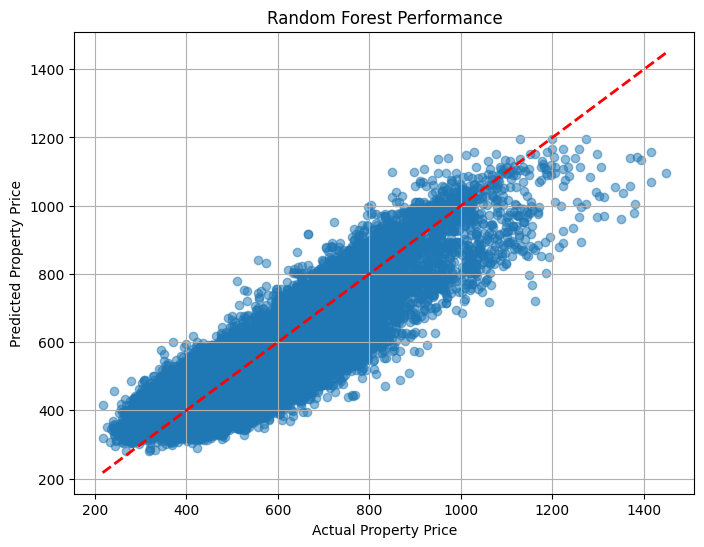

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, rf_pred_actual_test, alpha=0.5)  # alpha for transparency
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)  # Ideal line
plt.xlabel("Actual Property Price")
plt.ylabel("Predicted Property Price")
plt.title("Random Forest Performance")
plt.grid(True)
plt.show()

In [30]:
# ==========================================================
# 7. TRAIN, TUNE & EVALUATE — MLP REGRESSOR (with RandomizedSearchCV)
# ==========================================================
print(" Training MLP Regressor (Neural Network) using RandomizedSearchCV...")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# ----------------------------------------------
# 1. Define the hyperparameter search space
# ----------------------------------------------
# MLP has many tunable settings; we’ll keep a compact and efficient range.
param_dist_mlp = {
    'model__hidden_layer_sizes': [(64, 32), (128, 64), (256, 128)],  # neurons per layer
    'model__activation': ['relu', 'tanh'],                            # activation functions
    'model__alpha': uniform(1e-5, 1e-3),                              # L2 regularization term
    'model__learning_rate_init': uniform(1e-4, 5e-3),                 # initial learning rate
    'model__solver': ['adam'],                               # optimization solver
}

# ----------------------------------------------
# 2. Setup the RandomizedSearchCV
# ----------------------------------------------
# RandomizedSearchCV randomly picks parameter combinations.
# This is much faster than GridSearchCV for neural networks.
rs_mlp = RandomizedSearchCV(
    estimator=mlp_pipe,                # pipeline (preprocessing + MLP)
    param_distributions=param_dist_mlp,
    n_iter=10,                         # number of random parameter combinations to test
    cv=3,                              # 3-fold cross-validation
    n_jobs=2,                          # use 2 CPU cores
    random_state=42,                   # for reproducibility
    verbose=2,                          # prints progress for each trial
    scoring='neg_root_mean_squared_error'
)

# ----------------------------------------------
# 3. Train the MLP model with RandomizedSearchCV
# ----------------------------------------------
print(" Performing hyperparameter tuning for MLP (this may take a while) " )
rs_mlp.fit(X_train, y_train_log)

# ----------------------------------------------
# 4. Retrieve the best estimator (model with best params)
# ----------------------------------------------
best_mlp = rs_mlp.best_estimator_
print("\n Best MLP Regressor Parameters Found:")
print(rs_mlp.best_params_)

# ----------------------------------------------
# 5. Predict on the test set
# ----------------------------------------------
mlp_pred_log_test = best_mlp.predict(X_test)

# Predict on the training set
mlp_pred_log_train = best_mlp.predict(X_train)

# Convert predictions back to actual $/sqft
y_test_actual = np.expm1(y_test_log)
mlp_pred_actual_test = np.expm1(mlp_pred_log_test)

y_train_actual = np.expm1(y_train_log)
mlp_pred_actual_train = np.expm1(mlp_pred_log_train)

# ----------------------------------------------
# 6. Evaluate model performance
# ----------------------------------------------
# Evaluate on Test Set
mlp_rmse_test = np.sqrt(mean_squared_error(y_test_actual, mlp_pred_actual_test))
mlp_mae_test = mean_absolute_error(y_test_actual, mlp_pred_actual_test)
mlp_r2_test = r2_score(y_test_actual, mlp_pred_actual_test)

# Evaluate on Training Set
mlp_rmse_train = np.sqrt(mean_squared_error(y_train_actual, mlp_pred_actual_train))
mlp_mae_train = mean_absolute_error(y_train_actual, mlp_pred_actual_train)
mlp_r2_train = r2_score(y_train_actual, mlp_pred_actual_train)


# ----------------------------------------------
# 7. Display results
# ----------------------------------------------
print("\n MLP Regressor Model Evaluation (with RandomizedSearchCV):")
print(f"Cross-Validation RMSE: {-rs_mlp.best_score_:.4f}")

print("\n Test Set Metrics:")
print(f"Test RMSE: {mlp_rmse_test:,.2f} $/sqft")
print(f"MAE: {mlp_mae_test:,.2f} $/sqft")
print(f"R²: {mlp_r2_test:.4f}")

print("\n Training Set Metrics:")
print(f"Train RMSE: {mlp_rmse_train:,.2f} $/sqft")
print(f"Train MAE: {mlp_mae_train:,.2f} $/sqft")
print(f"Train R²: {mlp_r2_train:.4f}\n")

 Training MLP Regressor (Neural Network) using RandomizedSearchCV...
 Performing hyperparameter tuning for MLP (this may take a while) 
Fitting 3 folds for each of 10 candidates, totalling 30 fits

 Best MLP Regressor Parameters Found:
{'model__activation': 'tanh', 'model__alpha': 5.666566321361543e-05, 'model__hidden_layer_sizes': (256, 128), 'model__learning_rate_init': 0.0023803499210851794, 'model__solver': 'adam'}

 MLP Regressor Model Evaluation (with RandomizedSearchCV):
Cross-Validation RMSE: 0.1598

 Test Set Metrics:
Test RMSE: 78.82 $/sqft
MAE: 64.30 $/sqft
R²: 0.7149

 Training Set Metrics:
Train RMSE: 78.11 $/sqft
Train MAE: 63.76 $/sqft
Train R²: 0.7235



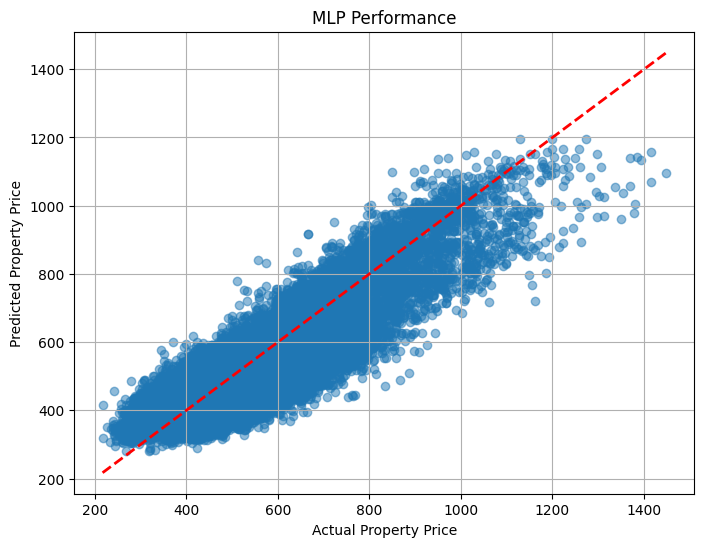

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, rf_pred_actual_test, alpha=0.5)  # alpha for transparency
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)  # Ideal line
plt.xlabel("Actual Property Price")
plt.ylabel("Predicted Property Price")
plt.title("MLP Performance")
plt.grid(True)
plt.show()

 Model Comparison Summary:
               Model  RMSE ($/sqft)  MAE ($/sqft)   R²
1      Random Forest          77.69         63.51 0.72
2      MLP Regressor          78.82         64.30 0.71
0  Linear Regression          88.10         71.58 0.64 



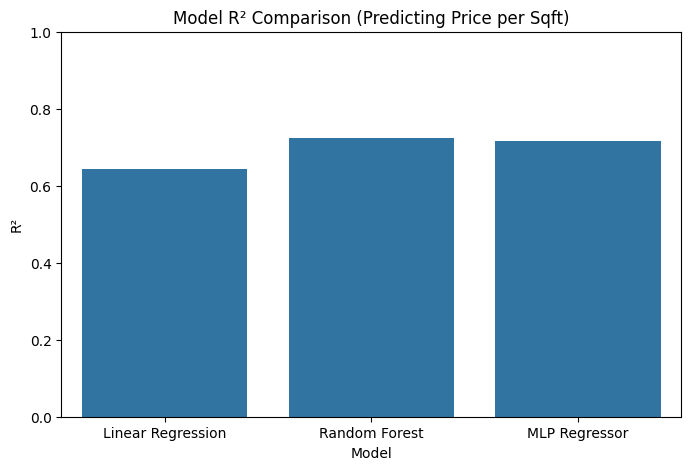

In [32]:
# ==========================================================
# 8. COMPARE ALL MODELS TOGETHER
# ==========================================================
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'MLP Regressor'],
    'RMSE ($/sqft)': [lr_rmse_test, rf_rmse_test, mlp_rmse_test],
    'MAE ($/sqft)': [lr_mae_test, rf_mae_test, mlp_mae_test],
    'R²': [lr_r2_test, rf_r2_test, mlp_r2_test]
})

print(" Model Comparison Summary:")
print(results_df.sort_values(by='R²', ascending=False), "\n")

# Visualize R² values for comparison
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='R²')
plt.title("Model R² Comparison (Predicting Price per Sqft)")
plt.ylim(0,1)
plt.show()


 Forecasting Next 5 Years Based on Best Model Performance

 Best Model Selected for Forecast: Random Forest

 Average Predicted Price per Sqft for 2025 (Base Year): $500.23

 Projected Average Price per Sqft (2026–2030):

 2026: $540.24 per sqft
 2027: $583.46 per sqft
 2028: $630.14 per sqft
 2029: $680.55 per sqft
 2030: $735.00 per sqft


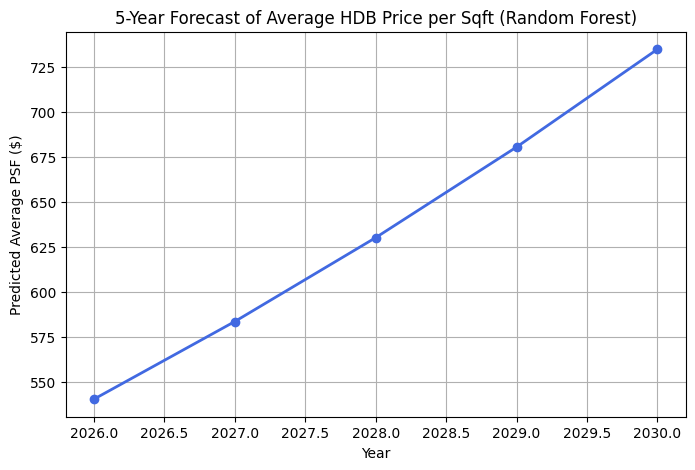

In [34]:
# ==========================================================
# 9. FORECAST NEXT 5 YEARS USING BEST MODEL
# ==========================================================
print("\n Forecasting Next 5 Years Based on Best Model Performance")


# 1. Identify the model with the highest R² score
best_model_index = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_index, 'Model']
print(f"\n Best Model Selected for Forecast: {best_model_name}")

# 2. Select the corresponding trained (fitted) model
# GridSearchCV / RandomizedSearchCV returns a *fitted clone*, 
# so we use best_lr / best_rf / best_mlp instead of the pipeline templates.
if best_model_name == 'Linear Regression':
    best_model = best_lr
elif best_model_name == 'Random Forest':
    best_model = best_rf
else:
    best_model = best_mlp
    

# Compute the 2025 base predicted mean PSF
y_pred_log_2025 = best_model.predict(X_test)
y_pred_psf_2025 = np.expm1(y_pred_log_2025)
base_psf_2025 = y_pred_psf_2025.mean()

print(f"\n Average Predicted Price per Sqft for 2025 (Base Year): ${base_psf_2025:,.2f}")

# 3. Simulate annual 8.0% growth in PSF values from 2026–2030
# The growth factor 8.0%  mimics expected annual property appreciation.
future_years = [2026, 2027, 2028, 2029, 2030]
forecast_means = []

print("\n Projected Average Price per Sqft (2026–2030):\n")

for i, year in enumerate(future_years, start=1):
    fut = X_test.copy()                       # reuse test structure (same feature schema)
    fut_pred_log = best_model.predict(fut)    # predict log(PSF)
    fut_pred_psf = np.expm1(fut_pred_log) * ((1.08) ** i)  # compound 8.0%  annual growth
    forecast_means.append(fut_pred_psf.mean())
    print(f" {year}: ${fut_pred_psf.mean():,.2f} per sqft")

# 4. Plot forecast trend
plt.figure(figsize=(8,5))
plt.plot(future_years, forecast_means, marker='o', linewidth=2, color='royalblue')
plt.title(f"5-Year Forecast of Average HDB Price per Sqft ({best_model_name})")
plt.xlabel("Year")
plt.ylabel("Predicted Average PSF ($)")
plt.grid(True)
plt.show()




 Forecasting Next 5 Years Based on Best Model Performance

 Average Predicted Price per Sqft for 2025 (Base Year): $500.23

 Best Model Selected for Forecast: Random Forest



 Enter expected annual growth rate in % (e.g., 8 for 8%):  abcd


Invalid input. Using default growth rate of 8%.

 Using an annual growth rate of 8.0% for forecast projections.

 Projected Average Price per Sqft (2026–2030):

 2026: $540.24 per sqft
 2027: $583.46 per sqft
 2028: $630.14 per sqft
 2029: $680.55 per sqft
 2030: $735.00 per sqft


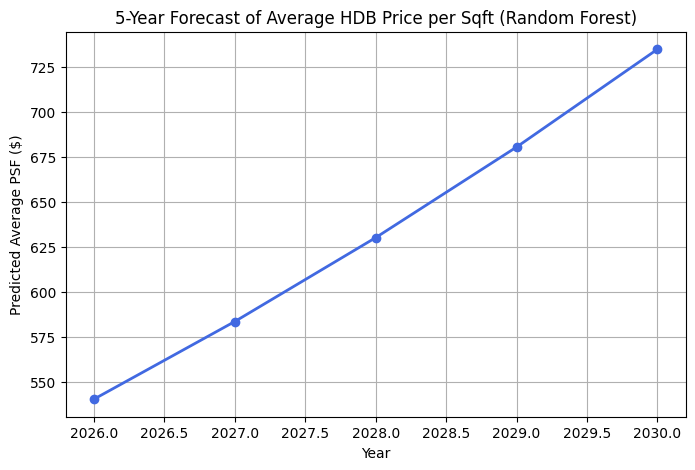

In [35]:
# ==========================================================
# 9. ADDITIONAL SECTION: INTERACTIVE GROWTH RATE SECTION
# ==========================================================
print("\n Forecasting Next 5 Years Based on Best Model Performance")

# Compute the 2025 base predicted mean PSF
y_pred_log_2025 = best_model.predict(X_test)
y_pred_psf_2025 = np.expm1(y_pred_log_2025)
base_psf_2025 = y_pred_psf_2025.mean()

print(f"\n Average Predicted Price per Sqft for 2025 (Base Year): ${base_psf_2025:,.2f}")

# 1. Identify the model with the highest R² score
best_model_index = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_index, 'Model']
print(f"\n Best Model Selected for Forecast: {best_model_name}")

# 2. Select the corresponding trained (fitted) model
if best_model_name == 'Linear Regression':
    best_model = best_lr
elif best_model_name == 'Random Forest':
    best_model = best_rf
else:
    best_model = best_mlp

# 3. Ask user to input growth rate (as percentage)
growth_input = input("\n Enter expected annual growth rate in % (e.g., 8 for 8%): ")
try:
    growth_rate = float(growth_input) / 100
except ValueError:
    print("Invalid input. Using default growth rate of 8%.")
    growth_rate = 0.08

print(f"\n Using an annual growth rate of {growth_rate*100:.1f}% for forecast projections.")

# 4. Forecast next 5 years dynamically
future_years = [2026, 2027, 2028, 2029, 2030]
forecast_means = []

print("\n Projected Average Price per Sqft (2026–2030):\n")

for i, year in enumerate(future_years, start=1):
    fut = X_test.copy()
    fut_pred_log = best_model.predict(fut)
    fut_pred_psf = np.expm1(fut_pred_log) * ((1 + growth_rate) ** i)
    forecast_means.append(fut_pred_psf.mean())
    print(f" {year}: ${fut_pred_psf.mean():,.2f} per sqft")

# 5. Plot forecast trend
plt.figure(figsize=(8,5))
plt.plot(future_years, forecast_means, marker='o', linewidth=2, color='royalblue')
plt.title(f"5-Year Forecast of Average HDB Price per Sqft ({best_model_name})")
plt.xlabel("Year")
plt.ylabel("Predicted Average PSF ($)")
plt.grid(True)
plt.show()


In [36]:
# ==========================================================
# 10. INSIGHTS — AVERAGE PREDICTED PSF BY REGION
# ==========================================================
region_preds_log = best_model.predict(X_test)
region_preds = np.expm1(region_preds_log)
region_summary = pd.DataFrame({
    'region': X_test['region'],
    'predicted_psf': region_preds
}).groupby('region')['predicted_psf'].mean().sort_values(ascending=False)

overall_avg_psf = region_preds.mean()

print("\n Average Predicted Price per Sqft by Region:")
print(region_summary.round(2))

# ==========================================================
# FUTURE REGIONAL FORECAST (e.g. 2030 projection)
# ==========================================================
growth_rate = 0.08   # 8% annual growth
years_ahead = 5      # 2025 to 2030

# Compute 2030 projection using compound growth
future_region_summary = (region_summary * ((1 + growth_rate) ** years_ahead)).round(2)

# Combine both 2025 and 2030 values in one table
comparison_df = pd.DataFrame({
    'Region': region_summary.index,
    '2025 (Predicted PSF)': region_summary.values.round(2),
    '2030 (Projected PSF)': future_region_summary.values.round(2)
})

# Print formatted output
print("\n Predicted Average Price per Sqft by Region (2025 vs 2030):\n")
print(comparison_df.to_string(index=False))



 Average Predicted Price per Sqft by Region:
region
central region      624.10
north-east region   500.98
east region         484.57
west region         454.94
north region        437.89
Name: predicted_psf, dtype: float64

 Predicted Average Price per Sqft by Region (2025 vs 2030):

           Region  2025 (Predicted PSF)  2030 (Projected PSF)
   central region                624.10                917.01
north-east region                500.98                736.10
      east region                484.57                711.99
      west region                454.94                668.45
     north region                437.89                643.40


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categorie

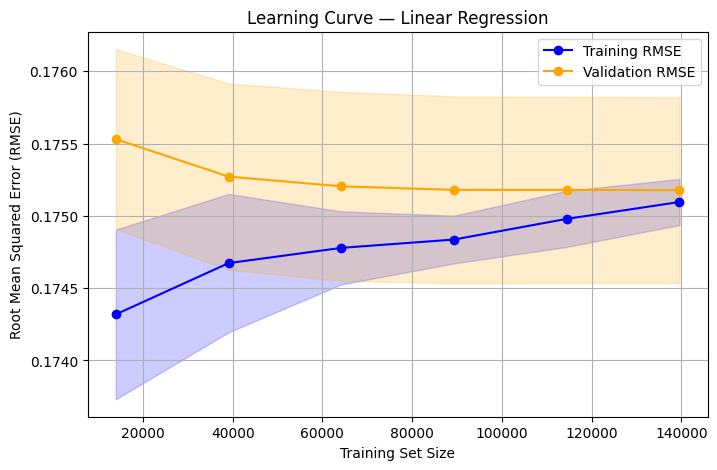

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be c

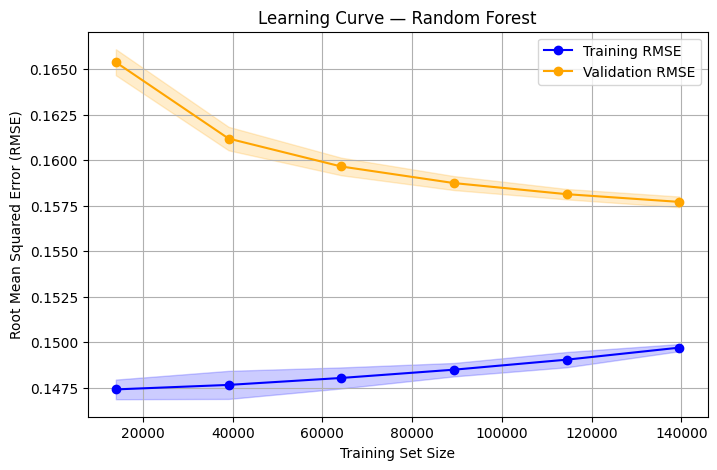

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categorie

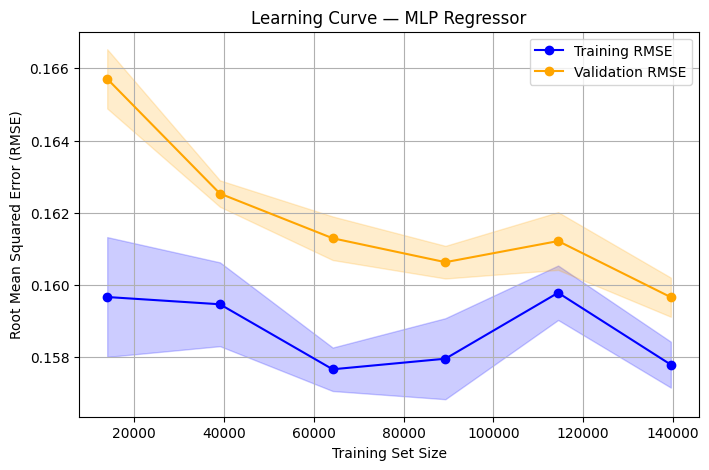

In [37]:
def plot_learning_curve(model, X, y, title, scoring='neg_root_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        shuffle=True,
        random_state=42
    )

    # Convert scores (negative RMSE) to positive RMSE
    train_rmse = -train_scores
    test_rmse = -test_scores

    # Compute means and stds
    train_mean = np.mean(train_rmse, axis=1)
    test_mean = np.mean(test_rmse, axis=1)
    train_std = np.std(train_rmse, axis=1)
    test_std = np.std(test_rmse, axis=1)

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training RMSE')
    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation RMSE')
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color='orange')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Root Mean Squared Error (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for each model
plot_learning_curve(best_lr, X_train, y_train_log, "Learning Curve — Linear Regression")
plot_learning_curve(best_rf, X_train, y_train_log, "Learning Curve — Random Forest")
plot_learning_curve(best_mlp, X_train, y_train_log, "Learning Curve — MLP Regressor")